# import

In [1]:
import numpy as np
import dimod
import matplotlib.pyplot as plt
import dwave_networkx as dnx
import networkx as nx
import minorminer
import minorminer.layout as mml
%matplotlib inline
import dwave.inspector
import matplotlib as mpl
import math
from datetime import datetime
from pathlib import Path  
import pandas as pd
import os

In [2]:
#freetoken="DEV-5fa1054cd25ed5a94ead77ab54c60e280f772f28"
#paidtoken="6HCl-4905ed959746710cfc6edae637828621490a45d7"

In [3]:
from dwave.system import DWaveSampler

# Use a D-Wave system as the sampler
f = open("token.txt", "r")
#sampler = DWaveSampler(solver=dict(topology__type='chimera'),token=f.read())
sampler = DWaveSampler(solver=dict(topology__type='zephyr'),token=f.read())

print("QPU {} was selected.".format(sampler.solver.name))


QPU Advantage2_prototype1.1 was selected.


In [4]:
#test if certain nodes are in the Zephyr graph
node_test = 72
node_test2 = -1
for link in sampler.edgelist:
    if node_test in link or node_test2 in link:
        print(link)

(72, 73)
(72, 76)
(72, 289)
(72, 292)
(72, 297)
(72, 300)
(72, 305)
(72, 313)
(72, 316)
(72, 321)
(72, 324)
(72, 329)
(72, 332)
(72, 337)
(72, 340)
(72, 345)
(72, 348)


In [5]:
#set a simulated annealer sampler
simsampler=dimod.SimulatedAnnealingSampler()

# functions

In [6]:
#define a function to turn lists of tuples (edges) into arrays
def TuptoArray(tuplist):
    list0=[]
    list1=[]
    for tup in tuplist:
        list0.append(tup[0])
        list1.append(tup[1])
    edgearray=np.array([list0,list1])
    return edgearray

In [7]:
#define functions to tile any hex or tri array to the right or down
def tile_right(inp_arr):
    add_arr = np.empty(shape=inp_arr.shape)
    
    for i in range(len(inp_arr)):
        for j in range(len(inp_arr[i])):
            qub=inp_arr[i][j]
            if qub in horizontals:
                add_arr[i][j]=64
            if qub in verticals:
                add_arr[i][j]=1   
    
    out_arr = inp_arr + add_arr
    return out_arr

def tile_left(inp_arr):
    sub_arr = np.empty(shape=inp_arr.shape)
    
    for i in range(len(inp_arr)):
        for j in range(len(inp_arr[i])):
            qub=inp_arr[i][j]
            if qub in horizontals:
                sub_arr[i][j]=64
            if qub in verticals:
                sub_arr[i][j]=1   
    
    out_arr = inp_arr - sub_arr
    return out_arr

def tile_down(inp_arr):
    add_arr = np.empty(shape=inp_arr.shape)
    
    for i in range(len(inp_arr)):
        for j in range(len(inp_arr[i])):
            qub=inp_arr[i][j]
            if qub in horizontals:
                add_arr[i][j]=1
            if qub in verticals:
                add_arr[i][j]=64   
    
    out_arr = inp_arr + add_arr
    return out_arr

In [8]:
def Reverse(tup):
    newtup=(tup[1],tup[0])
    return newtup

In [9]:
#define a function to tile the base hexs and tris to the desired lattice size
def NxN_tile(N,fold):
    
    #initialize the registries with the base arrays
    hex1reg=[]
    hex1reg.append(hex1base)
    hex2reg=[]
    hex2reg.append(hex2base)
    tri1reg=[]
    tri1reg.append(tri1base)
    tri2reg=[]
    tri2reg.append(tri2base)
    tri3reg=[]
    tri3reg.append(tri3base)
    tri4reg=[]
    tri4reg.append(tri4base)
    
    if fold==True:
        hex3reg=[]
        hex3reg.append(hex3base)
        hex4reg=[]
        hex4reg.append(hex4base)
        hex5reg=[]
        hex5reg.append(hex5base)
        tri5reg=[]
        tri5reg.append(tri5base)
        tri6reg=[]
        tri6reg.append(tri6base)
        tri7reg=[]
        tri7reg.append(tri7base)
        tri8reg=[]
        tri8reg.append(tri8base)
        tri9reg=[]
        tri9reg.append(tri9base)
    
    #tile layer 1 to the right, tile layer 2 to the left
    for i in range(N-1):
        hex1reg.append(tile_right(hex1reg[i]))
        hex2reg.append(tile_right(hex2reg[i]))
        tri1reg.append(tile_right(tri1reg[i]))
        tri2reg.append(tile_right(tri2reg[i]))
        tri3reg.append(tile_right(tri3reg[i]))
        tri4reg.append(tile_right(tri4reg[i]))
        if fold==True:
            hex4reg.append(tile_left(hex4reg[i]))
            tri6reg.append(tile_left(tri6reg[i]))
            tri7reg.append(tile_left(tri7reg[i]))
            tri8reg.append(tile_left(tri8reg[i]))
    for i in range(N-2):    
        if fold==True:
            hex5reg.append(tile_left(hex5reg[i]))
            tri9reg.append(tile_left(tri9reg[i]))
        
    #now every registry has the first row of hexs or tris
    hex1row=hex1reg
    hex2row=hex2reg
    tri1row=tri1reg
    tri2row=tri2reg
    tri3row=tri3reg
    tri4row=tri4reg
    if fold==True:
        hex3row=hex3reg
        hex4row=hex4reg
        hex5row=hex5reg
        tri5row=tri5reg
        tri6row=tri6reg
        tri7row=tri7reg
        tri8row=tri8reg
        tri9row=tri9reg

    for i in range(N-1):
        newrowhex1=[]
        for j in range(len(hex1row)):
            hex1reg.append(tile_down(hex1row[j]))
            newrowhex1.append(tile_down(hex1row[j]))
        hex1row=newrowhex1
        
        if fold==True:
            newrowhex3=[]
            for j in range(len(hex3row)):
                hex3reg.append(tile_down(hex3row[j]))
                newrowhex3.append(tile_down(hex3row[j]))
            hex3row=newrowhex3
            newrowhex5=[]
            for j in range(len(hex5row)):
                hex5reg.append(tile_down(hex5row[j]))
                newrowhex5.append(tile_down(hex5row[j]))
            hex5row=newrowhex5
            
        newrowtri1=[]
        for j in range(len(tri1row)):
            tri1reg.append(tile_down(tri1row[j]))
            newrowtri1.append(tile_down(tri1row[j]))
        tri1row=newrowtri1
        newrowtri2=[]
        for j in range(len(tri2row)):
            tri2reg.append(tile_down(tri2row[j]))
            newrowtri2.append(tile_down(tri2row[j]))
        tri2row=newrowtri2
        
        if fold==True:
            newrowtri7=[]
            for j in range(len(tri7row)):
                tri7reg.append(tile_down(tri7row[j]))
                newrowtri7.append(tile_down(tri7row[j]))
            tri7row=newrowtri7
            newrowtri8=[]
            for j in range(len(tri8row)):
                tri8reg.append(tile_down(tri8row[j]))
                newrowtri8.append(tile_down(tri8row[j]))
            tri8row=newrowtri8
        
    for i in range(N-2):
        newrowhex2=[]
        for j in range(len(hex2row)):
            hex2reg.append(tile_down(hex2row[j]))
            newrowhex2.append(tile_down(hex2row[j]))
        hex2row=newrowhex2
        
        if fold==True:
            newrowhex4=[]
            for j in range(len(hex4row)):
                hex4reg.append(tile_down(hex4row[j]))
                newrowhex4.append(tile_down(hex4row[j]))
            hex4row=newrowhex4
            
        newrowtri3=[]
        for j in range(len(tri3row)):
            tri3reg.append(tile_down(tri3row[j]))
            newrowtri3.append(tile_down(tri3row[j]))
        tri3row=newrowtri3
        newrowtri4=[]
        for j in range(len(tri4row)):
            tri4reg.append(tile_down(tri4row[j]))
            newrowtri4.append(tile_down(tri4row[j]))
        tri4row=newrowtri4
        
        if fold==True:
            newrowtri5=[]
            for j in range(len(tri5row)):
                tri5reg.append(tile_down(tri5row[j]))
                newrowtri5.append(tile_down(tri5row[j]))
            tri5row=newrowtri5
            newrowtri6=[]
            for j in range(len(tri6row)):
                tri6reg.append(tile_down(tri6row[j]))
                newrowtri6.append(tile_down(tri6row[j]))
            tri6row=newrowtri6
            newrowtri9=[]
            for j in range(len(tri9row)):
                tri9reg.append(tile_down(tri9row[j]))
                newrowtri9.append(tile_down(tri9row[j]))
            tri9row=newrowtri9
            
    if fold==False:
        hex3reg=[]
        hex4reg=[]
        hex5reg=[]
        tri5reg=[]
        tri6reg=[]
        tri7reg=[]
        tri8reg=[]
        tri9reg=[]
        
    return hex1reg,hex2reg,hex3reg,hex4reg,hex5reg,tri1reg,tri2reg,tri3reg,tri4reg,tri5reg,tri6reg,tri7reg,tri8reg,tri9reg

In [10]:
def RegsToTups(all_regs):
    alledges=[]
    allnodes=[]
    for arr in all_regs:
        list0=arr[0]
        list1=arr[1]
        for i in range(len(list0)):
            qubit0=int(list0[i])
            qubit1=int(list1[i])
            alledges.append((qubit0,qubit1))
            allnodes.append(qubit0)
            allnodes.append(qubit1)
    allnodes=set(allnodes)
    return alledges,allnodes

In [11]:
def magnetization(response):
    mags=[]
    for i in range(len(response.lowest().record)):
        run_pms=response.record[i][0]
        mags.append(np.mean(run_pms))

    avgmag=np.mean(mags)

    return mags,avgmag

In [12]:
# function to fill in missing couplers by using another coupler
def find_intersection(missedge,allnodes,missingcoups,missingqs):

    #these are the two qubits constituting the missing coupler
    q0m = missedge[0]
    q1m = missedge[1]

    # a list of all of the couplers associated with q0m and q1m
    candidates = []
    # from candidates, all of the qubits connected to q0m and those connected to q1m
    q0mcoups = []
    q1mcoups = []

    if (q0m not in missingqs and q1m not in missingqs):
        for availedge in sampler.edgelist:
            q0a = availedge[0]
            q1a = availedge[1]

            if (q0a == q0m or q1a == q1m or q0a == q1m or q1a == q0m):
                candidates.append(availedge)

        for cand in candidates:
            if (cand[0] == q0m or cand[1] == q0m):
                q0mcoups.append(cand[0])
                q0mcoups.append(cand[1])
            if (cand[0] == q1m or cand[1] == q1m):
                q1mcoups.append(cand[0])
                q1mcoups.append(cand[1])

    else:
        if q0m in missingqs:
            print(q0m, "missing")
            missingqubit=q0m
        if q1m in missingqs:
            missingqubit=q1m
            print(q1m, "missing")
        
        
        

    for qubit in q0mcoups:
        if qubit == q0m:
            q0mcoups.remove(qubit)
    for qubit in q1mcoups:
        if qubit == q1m:
            q1mcoups.remove(qubit)
            
    q0mcoups = set(q0mcoups)
    q1mcoups = set(q1mcoups)

    #find the intersection
    intersection = q0mcoups.intersection(q1mcoups)
    intersection = list(intersection)
        
    #for every intersection qubit, check if it is already in use in the embedding
    #if no good intersection exists, the missing coupler is unresolved
    if len(intersection) != 0:
        goodinter=[]
        for inter in intersection:
            if inter not in allnodes:
                goodinter.append(inter)
        if len(goodinter)==0:
            unresolved=True
        else:
            unresolved=False
    else:
        unresolved=True
        

    return intersection,goodinter,unresolved


In [13]:
def resolve_unresolved(unres, allnodes, missingqs):

    #these are the two qubits constituting the missing coupler
    q0m = unres[0]
    q1m = unres[1]

    # a list of all of the couplers associated with q0m and q1m
    candidates = []
    # from candidates, all of the qubits connected to q0m and those connected to q1m
    q0mcoups = []
    q1mcoups = []

    if (q0m not in missingqs and q1m not in missingqs):
        for availedge in sampler.edgelist:
            q0a = availedge[0]
            q1a = availedge[1]

            if (q0a == q0m or q1a == q1m or q0a == q1m or q1a == q0m):
                candidates.append(availedge)

        for cand in candidates:
            if (cand[0] == q0m or cand[1] == q0m):
                q0mcoups.append(cand[0])
                q0mcoups.append(cand[1])
            if (cand[0] == q1m or cand[1] == q1m):
                q1mcoups.append(cand[0])
                q1mcoups.append(cand[1])

    else:
        print("one or more of the qubits in this coupler are missing")
        

    for qubit in q0mcoups:
        if qubit == q0m:
            q0mcoups.remove(qubit)
    for qubit in q1mcoups:
        if qubit == q1m:
            q1mcoups.remove(qubit)

    q0mcontigs = list(set(q0mcoups))
    q1mcontigs = list(set(q1mcoups))

#     print(q0mcontigs)
#     print(q1mcontigs)

    candidates = []
    for q0 in q0mcontigs:
        for q1 in q1mcontigs:
            if (((q0, q1) in sampler.edgelist or Reverse(
                (q0, q1)) in sampler.edgelist)
                    and (q0 not in allnodes and q1 not in allnodes)):
                candidates.append((q0, q1))

    for cand in candidates:

        two_2chains = [(q0m, cand[0]), (q1m, cand[1])]
        verified_2chains = []
        for chain in two_2chains:
            if chain in sampler.edgelist:
                verified_2chains.append(chain)
            else:
                if Reverse(chain) in sampler.edgelist:
                    verified_2chains.append(Reverse(chain))

            if (len(verified_2chains) == 2
                    and (cand in sampler.edgelist
                         or Reverse(cand) in sampler.edgelist)):
                finalafm = cand
                final_2chains = verified_2chains
                break

    return finalafm, final_2chains

In [14]:
def check_nodes(nodes):
    missingqubits = []
    for node in nodes:
        if node not in sampler.nodelist:
            missingqubits.append(node)
    return missingqubits

In [15]:
def check_edges(edges):
    missingedges=[]
    for edge in edges:
        if edge not in sampler.edgelist and Reverse(edge) not in sampler.edgelist:
            missingedges.append(edge)
    return missingedges

In [16]:
def remove_tup_repeats(edges):
    edges_norepeats=[]
    for edge in edges:
        if (edge not in edges_norepeats and Reverse(edge) not in edges_norepeats):
            edges_norepeats.append(edge)
    return edges_norepeats

In [17]:
def DocName(jafm,k2,h1,h2,s):
    
    str1="J="+str(jafm)
    str2="h1,h2,k2,s="+str(h1)+","+str(h2)+","+str(k2)+","+str(s)
    now = datetime.now()
    str3 = now.strftime("%m-%d-%y__%H-%M-%S")
    
    Documentname=str1+'__'+str2+'__'+str3
    
    return Documentname

In [18]:
def set_jkhs(jafm, k2, h1, s):

    h2 = h1 / 2

    #make an array of these values
    paramsarray = np.array([['jafm', 'k2', 'h1', 'h2', 's'],
                            [jafm, k2, h1, h2, s]])

    return paramsarray

In [19]:
def checks(alledges,allnodes):

    #remove repeats
#     print(len(alledges),"edges to start with")
    edges_norepeats = remove_tup_repeats(alledges)
#     print(len(edges_norepeats),"edges without repeats")

    #check for missing qubits
    missingqs=check_nodes(allnodes)
#     print("missing qubits:",missingqs)

    #check for missing couplers
    missingcoups=check_edges(edges_norepeats)
#     print("missing couplers:",missingcoups)

    ##### There are 2 types of missing couplers.
    ####### The easier one is a coupler that is itself missing or faulty.
    ######### We fix this by making one or both of the qubits into chain(s) and then connecting them.
    ####### The annoying case is when there is a missing qubit, 
    ######### which can have as many as 4 couplers associated with it (in this lattice)
    ######### Since all of these couplers are now faulty, we have to try to find other qubit(s) to make it work
    ######### Try to fix the missing qubits first

    ### for now let's just remove the couplers associated with the missing qubits
    missingqcoups=[]
    for missingq in missingqs:
        for coup in missingcoups:
            if (coup[0]==missingq or coup[1]==missingq):
                missingqcoups.append(coup)
#     print("coups associated with missing qubits",missingqcoups)
    for coup in missingqcoups:
#         print("removing",coup)
        missingcoups.remove(coup)
        edges_norepeats.remove(coup)


    #remove the missing ones
    for coup in missingcoups:
        edges_norepeats.remove(coup)
#     print(len(edges_norepeats),"couplers after removing missing couplers")


    #check the edges again after removing the missing ones (just in case)
    missingcoups2=check_edges(edges_norepeats)
#     print(len(missingcoups2),"missing couplers")

    # make a list of "stitching" couplers to resolve missing couplers
    surgery=[]
    # make a list of pairs of stitches:
    # if a missing coupler is (a,b) and their intersection is c, then we append:
    # ((a,c),(b,c)) to surgery pairs
    # this is because we want to make one of these a 2chain (strong FM), and the other an AFM coupling
    surgerypairs=[]
    #also make a list of unresolved missing couplers
    unresolved_missingcoups=[]
    for missingcoup in missingcoups:
        intersection, goodinters, unresolved = find_intersection(missingcoup,allnodes,missingcoups,missingqs)

        if unresolved==False:
            chooseintersection=goodinters[0]
            stitch1=(missingcoup[0],chooseintersection)
            stitch2=(missingcoup[1],chooseintersection)
            surgery.append(stitch1)
            surgery.append(stitch2)

            surgerypairs.append((stitch1,stitch2))
        if unresolved==True:
            unresolved_missingcoups.append(missingcoup)

#     print(len(surgerypairs),"pairs of stitches")

    #check the stitches
    missingcoups3=check_edges(surgery)
#     print(len(missingcoups3), "missing stitches")

    #make the coupler dictionary
    final_coups={}
    for edge in edges_norepeats:
        final_coups.update({edge:jafm})
    #add the stitches to the dictionary
    #also make a list of 2chains
    twochains=[]
    for surgerypair in surgerypairs:
        stitch0=surgerypair[0]
        stitch1=surgerypair[1]

        final_coups.update({stitch0:k2})
        twochains.append(stitch0)
        final_coups.update({stitch1:jafm})


    #do a check on the couplers
    missingcoups4=check_edges(list(final_coups.keys()))
#     print(len(missingcoups4),"missing couplers in the final couplers")

#     print("but, these are the unresolved missing couplers:", unresolved_missingcoups)

    #resolve the (still) unresolved couplers by using a pair of 2chains
    for unres in unresolved_missingcoups:
        finalafm, final_2chains=resolve_unresolved(unres,allnodes,missingqs)
        final_coups.update({finalafm:jafm})
        for twochain in final_2chains:
            twochains.append(twochain)
            final_coups.update({twochain:k2})

    #make a list of the final nodes
    final_nodes=[]
    for coup in final_coups.keys():
        final_nodes.append(coup[0])
        final_nodes.append(coup[1])
    final_nodes=list(set(final_nodes))
    #make a list of the nodes that are in a 2chain
    twochain_nodes=[]
    for tup in twochains:
        twochain_nodes.append(tup[0])
        twochain_nodes.append(tup[1])
    twochain_nodes=list(set(twochain_nodes))
    #make a list oof nodes that are not in a 2chain (aka "1chains")
    onechain_nodes=[]
    for node in final_nodes:
        if node not in twochain_nodes:
            onechain_nodes.append(node)
    onechain_nodes=list(set(onechain_nodes))

    #do a check on the couplers
    missingcoups5=check_edges(list(final_coups.keys()))
#     print(len(missingcoups5),"missing couplers in the final couplers")
    
    if len(missingcoups5)==0:
        goodtogo=1
    if len(missingcoups5)!=0:   
        goodtogo=0
    
    return final_coups,final_nodes,twochains,twochain_nodes,onechain_nodes,missingqs,goodtogo

In [20]:
def set_hs(final_nodes,onechain_nodes,twochain_nodes,h1,h2):
    hdict={}
    for node in final_nodes:
        if node in onechain_nodes:
            hdict.update({node:h1})
        if node in twochain_nodes:
            hdict.update({node:h2})
        if (node in onechain_nodes and node in twochain_nodes):
            print("error")
    return hdict

In [21]:
def classify_Js(final_coups,twochains,twochain_nodes,onechain_nodes):
    
    J11coups=[]
    J22coups=[]
    J12coups=[]
    
    for coup in final_coups:
        if (coup not in twochains and Reverse(coup) not in twochains):
            q0=coup[0]
            q1=coup[1]
            if (q0 in twochain_nodes and q1 in twochain_nodes):
                J22coups.append(coup)
#                 print(coup,"a J22")
            elif (q0 in onechain_nodes and q1 in onechain_nodes):
                J11coups.append(coup)
#                 print(coup,"a J11")
            elif ((q0 in twochain_nodes) ^ (q1 in twochain_nodes)):
                J12coups.append(coup)
#                 print(coup,"a J12")
            else:
                print("ERROR",coup)
            
    return J11coups, J22coups, J12coups

# base hexs and tris

In [22]:
#which qubits are vertical qubits (lying on a vertical line) and which are horizontal?
#this is important for the naming convention
horizontals=[*range(288)]
verticals=[*range(288,575)]

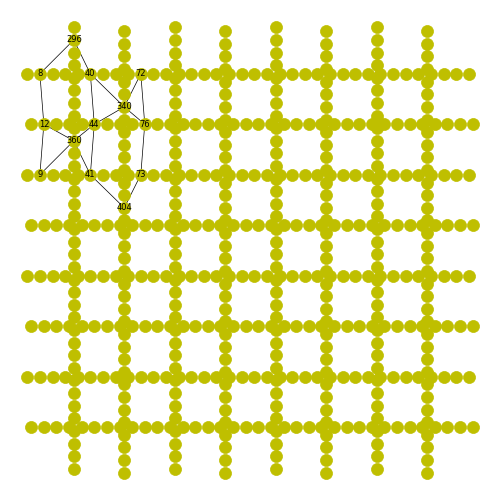

In [23]:
#this is layer 1
#define the 2 base hexagons and the 4 base triangles
hex1nodes=[296,40,44,360,12,8]
hex2nodes=[340,76,73,404,41,44]
hex1edges=[]
hex2edges=[]

for i in range(len(hex1nodes)):
    if i<len(hex1nodes)-1:
        hex1edges.append((hex1nodes[i],hex1nodes[i+1]))
    if i==len(hex1nodes)-1:
        hex1edges.append((hex1nodes[i],hex1nodes[0]))
        
for i in range(len(hex2nodes)):
    if i<len(hex2nodes)-1:
        hex2edges.append((hex2nodes[i],hex2nodes[i+1]))
    if i==len(hex2nodes)-1:
        hex2edges.append((hex2nodes[i],hex2nodes[0]))
    
tri1edges=[(40,340),(340,44),(44,40)]
tri2edges=[(72,76),(76,340),(340,72)]
tri3edges=[(44,41),(41,360),(360,44)]
tri4edges=[(12,360),(360,9),(9,12)]

hextriedges=hex1edges+hex2edges+tri1edges+tri2edges+tri3edges+tri4edges
hextriedges=list(set(hextriedges))

hextrinodes=[]
for tup in hextriedges:
    hextrinodes.append(tup[0])
    hextrinodes.append(tup[1])
hextrinodes=list(set(hextrinodes))

hextrilabels={}
for node in hextrinodes:
    hextrilabels.update({node:str(node)})

plt.ion()
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["figure.dpi"]=50

Kag=dnx.zephyr_graph(4,edge_list=hextriedges)
dnx.draw_zephyr(Kag,labels=hextrilabels,node_color='y')
plt.show()

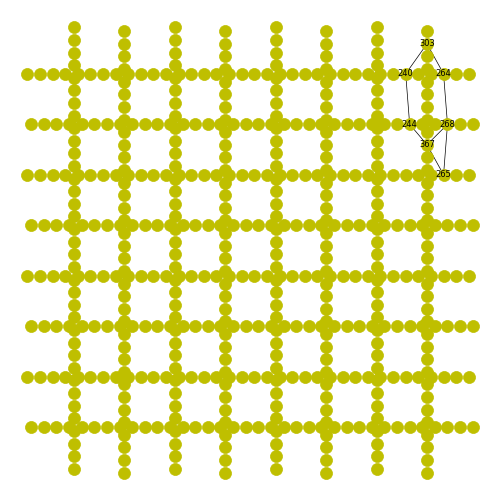

In [24]:
#this is the connection between layer 1 and layer 2
#define the 1 base hexagon and the 1 base triangle
hex3nodes=[303,240,244,367,268,264]
hex3edges=[]

for i in range(len(hex3nodes)):
    if i<len(hex3nodes)-1:
        hex3edges.append((hex3nodes[i],hex3nodes[i+1]))
    if i==len(hex3nodes)-1:
        hex3edges.append((hex3nodes[i],hex3nodes[0]))
    
tri5edges=[(268,367),(367,265),(265,268)]

#"con" denotes connection
hextriedges_con=hex3edges+tri5edges
hextriedges_con=list(set(hextriedges_con))

hextrinodes_con=[]
for tup in hextriedges_con:
    hextrinodes_con.append(tup[0])
    hextrinodes_con.append(tup[1])
hextrinodes_con=list(set(hextrinodes_con))

hextrilabels_con={}
for node in hextrinodes_con:
    hextrilabels_con.update({node:str(node)})

plt.ion()
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["figure.dpi"]=50

Kag=dnx.zephyr_graph(4,edge_list=hextriedges_con)
dnx.draw_zephyr(Kag,labels=hextrilabels_con,node_color='y')
plt.show()

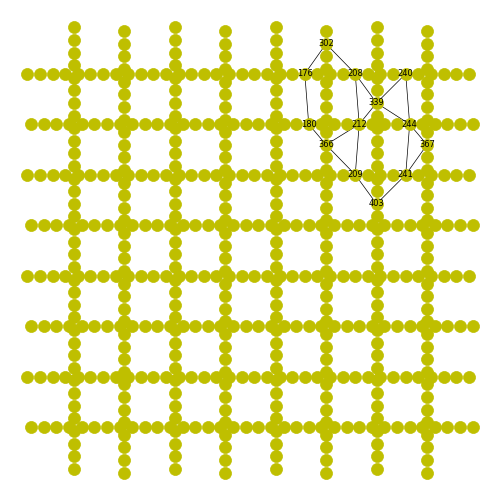

In [25]:
#this is layer 2
#define the 2 base hexagons and the 4 base triangles
hex4nodes=[339,212,209,403,241,244]
hex5nodes=[302,176,180,366,212,208]
hex4edges=[]
hex5edges=[]

for i in range(len(hex4nodes)):
    if i<len(hex4nodes)-1:
        hex4edges.append((hex4nodes[i],hex4nodes[i+1]))
    if i==len(hex4nodes)-1:
        hex4edges.append((hex4nodes[i],hex4nodes[0]))
        
for i in range(len(hex5nodes)):
    if i<len(hex5nodes)-1:
        hex5edges.append((hex5nodes[i],hex5nodes[i+1]))
    if i==len(hex5nodes)-1:
        hex5edges.append((hex5nodes[i],hex5nodes[0]))

tri6edges=[(244,241),(241,367),(367,244)]        
tri7edges=[(240,339),(339,244),(244,240)]
tri8edges=[(208,339),(339,212),(212,208)]
tri9edges=[(212,366),(366,209),(209,212)]

hextriedges2=hex4edges+hex5edges+tri6edges+tri7edges+tri8edges+tri9edges
hextriedges2=list(set(hextriedges2))

hextrinodes2=[]
for tup in hextriedges2:
    hextrinodes2.append(tup[0])
    hextrinodes2.append(tup[1])
hextrinodes2=list(set(hextrinodes2))

hextrilabels2={}
for node in hextrinodes2:
    hextrilabels2.update({node:str(node)})

plt.ion()
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["figure.dpi"]=50

Kag=dnx.zephyr_graph(4,edge_list=hextriedges2)
dnx.draw_zephyr(Kag,labels=hextrilabels2,node_color='y')
plt.show()

In [26]:
#redefine the base hexs and tris as arrays
hex1base = TuptoArray(hex1edges)
hex2base = TuptoArray(hex2edges)
hex3base = TuptoArray(hex3edges)
hex4base = TuptoArray(hex4edges)
hex5base = TuptoArray(hex5edges)
tri1base = TuptoArray(tri1edges)
tri2base = TuptoArray(tri2edges)
tri3base = TuptoArray(tri3edges)
tri4base = TuptoArray(tri4edges)
tri5base = TuptoArray(tri5edges)
tri6base = TuptoArray(tri6edges)
tri7base = TuptoArray(tri7edges)
tri8base = TuptoArray(tri8edges)
tri9base = TuptoArray(tri9edges)
#now we have a bunch of arrays that we can add to to create a larger lattice

# regs, embedding drawing

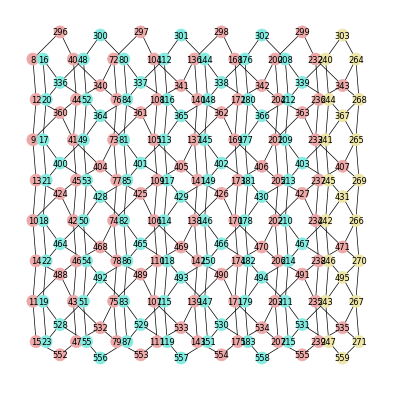

In [27]:
hex1reg,hex2reg,hex3reg,hex4reg,hex5reg,tri1reg,tri2reg,tri3reg,tri4reg,tri5reg,tri6reg,tri7reg,tri8reg,tri9reg=NxN_tile(N=4,fold=True)

allhexreg=np.array([hex1reg,hex2reg,hex3reg,hex4reg,hex5reg],dtype=object)
alltrireg=np.array([tri1reg,tri2reg,tri3reg,tri4reg,tri5reg,tri6reg,tri7reg,tri8reg,tri9reg],dtype=object)

layer1regs=hex1reg+hex2reg+tri1reg+tri2reg+tri3reg+tri4reg
connectionregs=hex3reg+tri5reg
layer2regs=hex4reg+hex5reg+tri6reg+tri7reg+tri8reg+tri9reg
allregs=layer1regs+connectionregs+layer2regs

layer1edges,layer1nodes=RegsToTups(layer1regs)
connectionedges,connectionnodes=RegsToTups(connectionregs)
layer2edges,layer2nodes=RegsToTups(layer2regs)
alledges,allnodes=RegsToTups(allregs)

layer1nodes=list(set(layer1nodes))
layer2nodes=list(set(layer2nodes))
connectionnodes=list(set(connectionnodes))

plt.ion()
plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams["figure.dpi"]=50

alllabels={}
for node in allnodes:
    alllabels.update({node:str(node)})

Zeph=dnx.zephyr_graph(4)
Kagall=dnx.zephyr_graph(4,edge_list=alledges)
Kag1=dnx.zephyr_graph(4,edge_list=layer1edges)
Kag2=dnx.zephyr_graph(4,edge_list=layer2edges)
Kagcon=dnx.zephyr_graph(4,edge_list=connectionedges)
Kag2andcon=dnx.zephyr_graph(4,edge_list=connectionedges+layer2edges)

allcolors=[]
for node in Kagall.nodes():
    if (node in layer1nodes and node in connectionnodes and node in layer2nodes):
        allcolors.append('#ede6a8')
    elif (node in layer1nodes and node in connectionnodes):
        allcolors.append('#ede6a8')
    elif (node in layer2nodes and node in connectionnodes):
        allcolors.append('#ede6a8')
    else:
        if node in layer1nodes:
            allcolors.append('#eda8a8')
        elif node in layer2nodes:
            allcolors.append('#83ebe0')
        elif node in connectionnodes:
            allcolors.append('#ede6a8')
        else:
            allcolors.append('none')

#allcolors=np.array([sorted(allnodes),allcolors])

#removing nodes and adding other edges for periodic boundary conditions
#Kagall.remove_node(8)
#Kagall.add_edge(*[296,16])
    
dnx.draw_zephyr(
    Kagall,
    #node_color = 'none'
    node_color=allcolors,
    labels=alllabels,
)
all_edges = np.array(Kagall.edges)
#dnx.draw_zephyr(Zeph)
#dnx.draw_zephyr(Kag1,node_color='#eda8a8',with_labels=True)
#dnx.draw_zephyr(Kag2,node_color='b',with_labels=True)
#dnx.draw_zephyr(Kag2andcon,node_color='#83ebe0',with_labels=True)
# plt.savefig('folded_kagome')
plt.show()

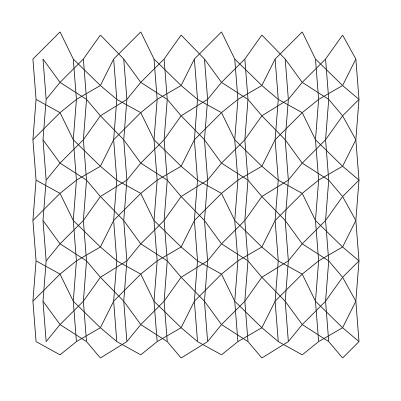

In [28]:
dnx.draw_zephyr(
    Kagall, node_color = 'none'
)

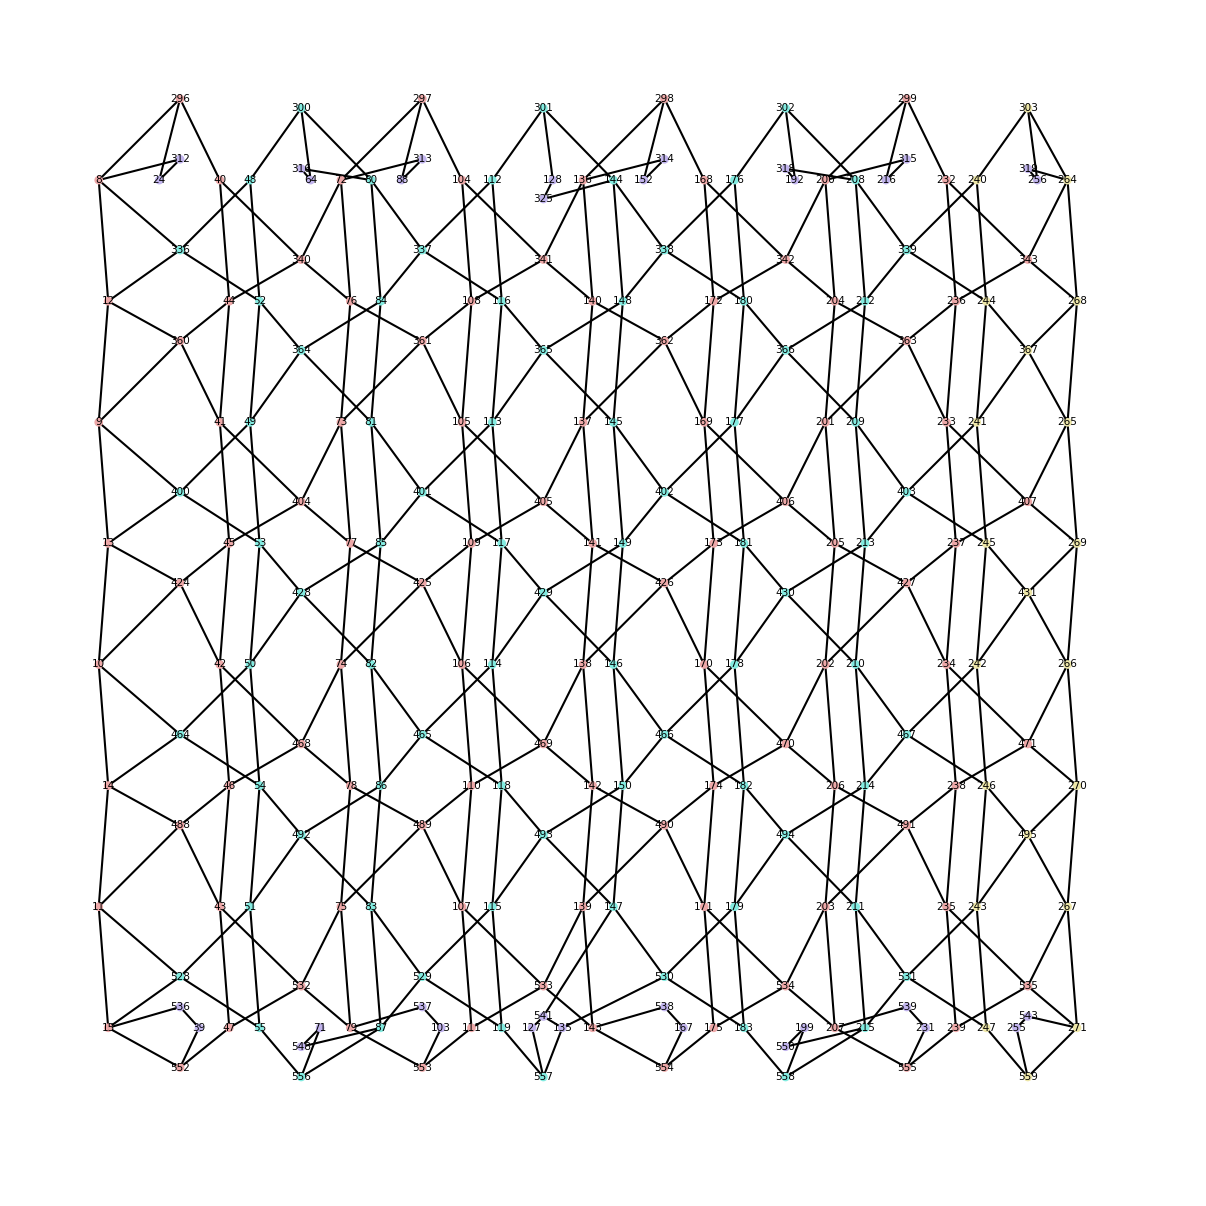

In [29]:
Kag_periodic = Kagall
to_delete = [16, 20, 17,21,18,22,19,23]
Kag_periodic.remove_nodes_from(to_delete)
to_add_edge = [(336,8), (336,12), (400,9), (400,13), (464,10), (464,14), (528,11), (528,15)]
for i in range(len(to_add_edge)):
    if to_add_edge[i] in sampler.edgelist:
        Kag_periodic.add_edge(*to_add_edge[i])
    elif Reverse(to_add_edge[i]) in sampler.edgelist:
        Kag_periodic.add_edge(*Reverse(to_add_edge[i]))
    else:
        print("Uh Oh you have a problem.")

#pre-handle the missing qubit 151
current_twochains = [(135,541)]
#remove 151 
to_delete = [151]
Kag_periodic.remove_nodes_from(to_delete)
#and add two chain (143 - 541)
to_add_missing = [(541,135), (557,135), (135, 530), (147,541)]
for i in range(len(to_add_missing)):
    if to_add_missing[i] in sampler.edgelist:
        Kag_periodic.add_edge(*to_add_missing[i])
    elif Reverse(to_add_missing[i]) in sampler.edgelist:
        Kag_periodic.add_edge(*Reverse(to_add_missing[i]))
    else:
        print("Uh Oh you have a problem.")

#add the new two chains for the triangles
to_add_triangles = []
to_add_triangles = [(24,312), (88,313), (152,314), (216,315), (319, 256), (318, 192), (128, 325), (64, 316), (536, 39), (537, 103), (538, 167), (539, 231), (543, 255), (550, 199), (71, 548)]
to_add_couplers_triangles = []
to_add_couplers_triangles = [(24,296), (312, 8), (313, 72), (88, 297), (314, 136), (152, 298), (216, 299), (315, 200), (319, 264), (256, 303), (318, 208), (192, 302), (325, 144), (128, 301), (64, 300), (316, 80),
(536, 15), (39, 552), (537, 79), (103, 553), (167, 554), (538, 143), (539, 207), (231, 555), (255, 559), (543, 271), (199, 558), (550, 215), (71, 556), (87, 548), (127, 541), (127, 557)]
to_all_add_triangles = to_add_triangles + to_add_couplers_triangles
for i in range(len(to_all_add_triangles)):
    if to_all_add_triangles[i] in sampler.edgelist:
        Kag_periodic.add_edge(*to_all_add_triangles[i])
    elif Reverse(to_all_add_triangles[i]) in sampler.edgelist:
        Kag_periodic.add_edge(*Reverse(to_all_add_triangles[i]))
    else:
        print("Uh Oh you have a problem.", to_all_add_triangles[i])

current_twochains = current_twochains + to_add_triangles

#take care of the coloring for two chains
added_twochains=[]
for coup in current_twochains:
    added_twochains.append(coup[0])
    added_twochains.append(coup[1])
added_twochains.append(127)
added_twochains=list(set(added_twochains))

plt.ion()
plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams["figure.dpi"]=150

allcolors=[]
alllabels={}
for node in Kag_periodic.nodes():
    check = 1
    if (node in layer1nodes and node in connectionnodes and node in layer2nodes):
        allcolors.append('#ede6a8')
    elif (node in layer1nodes and node in connectionnodes):
        allcolors.append('#ede6a8')
    elif (node in layer2nodes and node in connectionnodes):
        allcolors.append('#ede6a8')
    else:
        if node in layer1nodes:
            allcolors.append('#eda8a8')
        elif node in layer2nodes:
            allcolors.append('#83ebe0')
        elif node in connectionnodes:
            allcolors.append('#ede6a8')
        elif node in added_twochains:
            allcolors.append('#c1b4ed')
        else:
            check = 0
            allcolors.append('none')
    if check == 1:
        alllabels.update({node:str(node)})

#for node in Kagall.nodes():
#    if (node not in layer1nodes and node not in connectionnodes and node not in layer2nodes):
#        Kag_periodic.remove_node(node)

dnx.draw_zephyr(
    Kag_periodic,
    node_color=allcolors,
    labels=alllabels,
    node_size = 10,
    font_size = 5
)

# mapping the Zephyr kagome to real space

In [30]:
#make a graph with majority rule, for the fourier transform. 
#for all pre-imposed two-chains, remove the second one, reconnect to other sites
#then cut open the periodic boundary condition
simplify_Kag_graph = nx.Graph()
big_graph = Kag_periodic
all_edges_kag = [e for e in big_graph.edges()] 
all_nodes_kag = []
for m in big_graph.nodes:
    edges_to_it = big_graph.edges(m)
    if len(edges_to_it) > 0:
        all_nodes_kag.append(m)
        simplify_Kag_graph.add_node(m)
for e in all_edges_kag:
    simplify_Kag_graph.add_edge(*e)

#remove the end edges
if True:
    for e in all_edges_kag:
        if e in to_add_edge:
            simplify_Kag_graph.remove_edge(*e)
        elif Reverse(e) in to_add_edge:
            simplify_Kag_graph.remove_edge(*Reverse(e))

#remove the second site of the two chains, and replug the graph
to_remove = []
to_add = []
node_remove = []
for twoch in current_twochains:
    #print("treating this 2chain", twoch)
    node_remove.append(twoch[1])
    temp_edges_to_modify = simplify_Kag_graph.edges(twoch[1])
    #print(temp_edges_to_modify)
    for edge in temp_edges_to_modify:
        #print("Modifying this edges", edge)
        to_remove.append(edge)
        if edge != twoch and edge != Reverse(twoch):
            new_link = twoch[1]
            for m in range(2):
                if edge[m] != twoch[1]:
                    new_link = edge[m]
            edge_add = (twoch[0], new_link)
            to_add.append(edge_add)


simplify_Kag_graph.remove_edges_from(to_remove)
simplify_Kag_graph.add_edges_from(to_add)
simplify_Kag_graph.remove_nodes_from(node_remove)

#get the "relaxed" graph for the Zephyr kagome lattice
#this is close to the ideal graph
#test, planar_embed = nx.check_planarity(simplify_Kag_graph)
#pos = nx.combinatorial_embedding_to_pos(planar_embed, fully_triangulate=True)
#pos=nx.spring_layout(simplify_Kag_graph, dim = 2, k=10,iterations = 1000, pos = pos, scale = 40)
#nx.draw(simplify_Kag_graph, pos, node_size = 25)


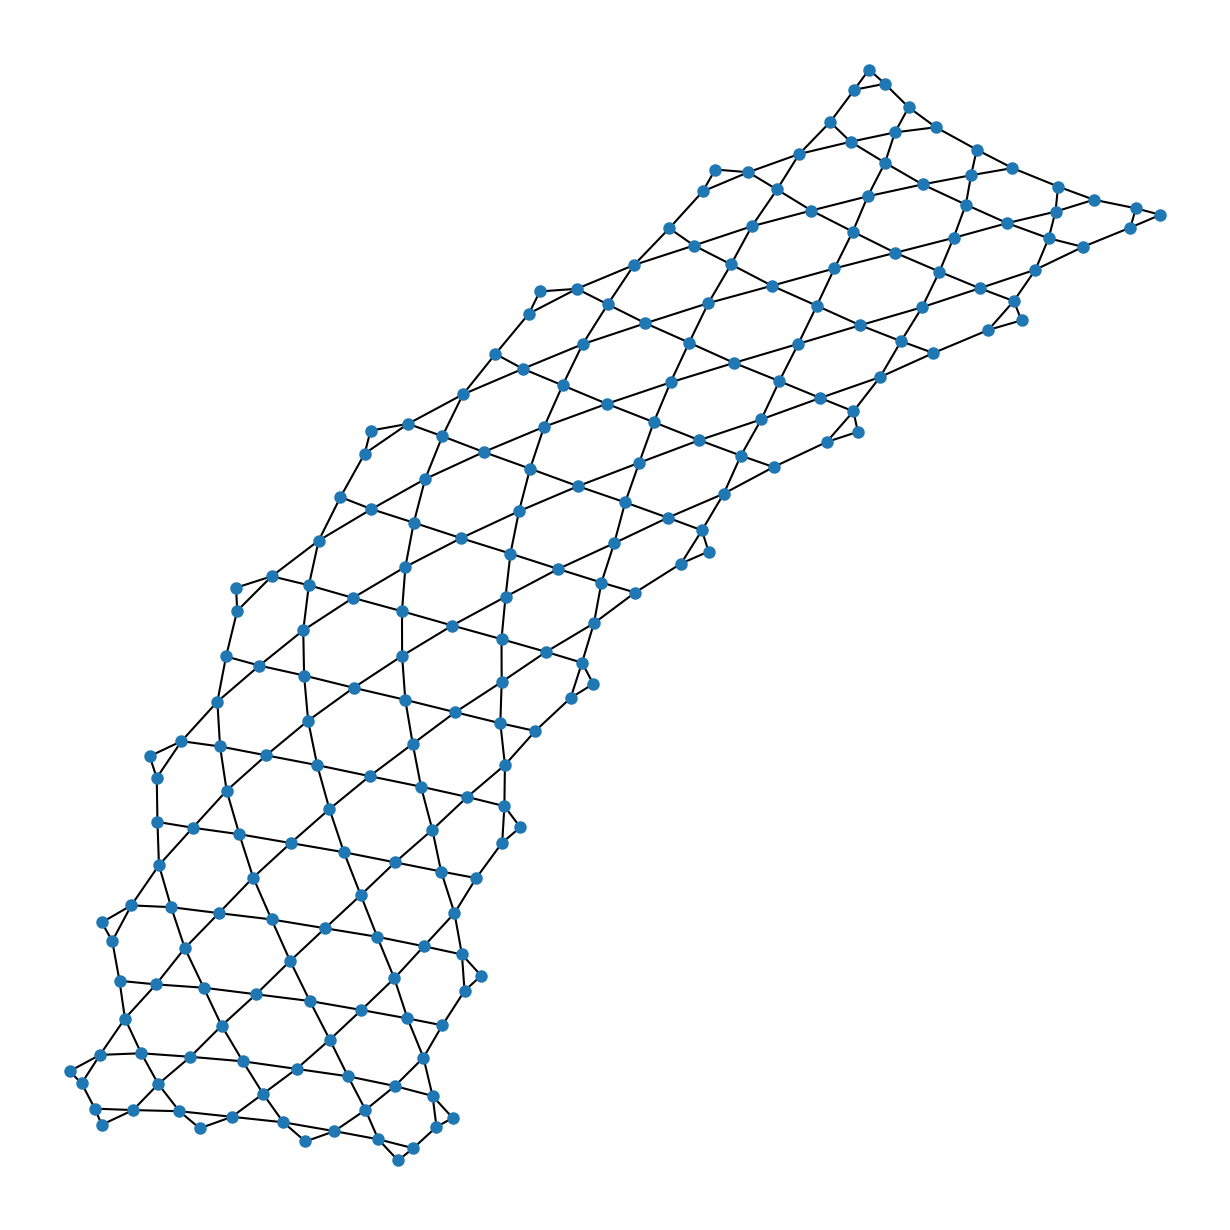

In [31]:
test, planar_embed = nx.check_planarity(simplify_Kag_graph)
pos = nx.combinatorial_embedding_to_pos(planar_embed, fully_triangulate=True)
pos=nx.spring_layout(simplify_Kag_graph, dim = 2, k=10,iterations = 1000, pos = pos, scale = 40)
nx.draw(simplify_Kag_graph, pos, node_size = 25)

# Making a real space Kagome lattice graph

for periodic lattice

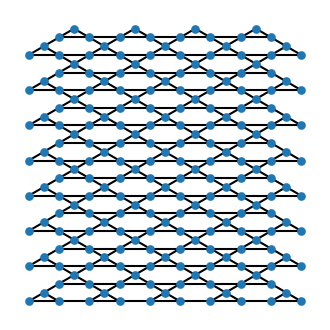

In [32]:
plt.ion()
plt.rcParams["figure.figsize"] = (2,2)
plt.rcParams["figure.dpi"]=150
# a kagome graph with the positions. start with a triangular graph
#make a triangular lattice:
N=40
g_trig = nx.triangular_lattice_graph(N,N, periodic=False, with_positions=True, create_using=None)
g_kag = nx.triangular_lattice_graph(N,N, periodic=False, with_positions=True, create_using=None)
complement_graph = nx.Graph()
pos={}
frac = 0.1
for node in g_trig.nodes:
    if node[0] % 2 == 1 and node[1] % 4 == 1:
        g_kag.remove_node(node)
    elif node[0] % 2 == 0 and node[1] % 4 == 3:
        g_kag.remove_node(node)
    else:    
        pos_here = np.array([1,np.sqrt(3)/2])*(np.array(node) + np.array([0.5, 0])*(node[1] % 2))
        pos.update({node:pos_here})

#here, pos has the positions on the 2D array for a Kagome lattice

#new mapping of nodes as integers
pos2 = {}
i = 0
DictRelabel = {}
for node in g_kag.nodes:
    DictRelabel.update({node:i})
    pos2.update({i:pos[node]})
    i += 1

g_kag2 = nx.relabel_nodes(g_kag, DictRelabel)

#cut some x and y boundaries for what we think is the correct graph

ymax = 16.1 #for only Kag1
ymax = 32.1 #for Kagall
#second pass:
filter_graph = g_kag2.copy()
for node in g_kag2.nodes:
    xval = pos2[node][0]
    yval = pos2[node][1]
    #if yval % (4*np.sqrt(3)/2) != 0:

    if xval < 0.0:
        filter_graph.remove_node(node)
        pos2.pop(node)
    elif xval > 9:
        filter_graph.remove_node(node)
        pos2.pop(node)
    elif yval > ymax*np.sqrt(3)/2 - 0.2:
        filter_graph.remove_node(node)
        pos2.pop(node)

filter_graph2 = filter_graph.copy()
if True:
    for node in filter_graph.nodes:
        xval = pos2[node][0]
        yval = pos2[node][1]
        if abs(yval/(np.sqrt(3)/2) % 4) > 0.1:
            if xval < 0.4:
                filter_graph2.remove_node(node)
                pos2.pop(node)
            elif xval > 8.6:
                filter_graph2.remove_node(node)
                pos2.pop(node)


nx.draw(filter_graph2, pos2, node_size = 10)

In [33]:
#compare the Zephyr graph (simplify_Kag_graph) with a filtered version that we have curated
GM = nx.isomorphism.GraphMatcher(simplify_Kag_graph, filter_graph2)
print(GM.is_isomorphic())
mapping_dict = GM.mapping

True


In [34]:
#get the dictionary
final_qubit_dictionary = {}
for qubit in mapping_dict.keys():
    position = pos2[mapping_dict[qubit]]
    final_qubit_dictionary.update({qubit:position})


In [35]:
#output the dictionary which gives a real space position for the qubits on the D-Wave machine.
final_qubit_dictionary

{24: array([0., 0.]),
 8: array([1., 0.]),
 12: array([2., 0.]),
 9: array([3., 0.]),
 13: array([4., 0.]),
 10: array([5., 0.]),
 14: array([6., 0.]),
 11: array([7., 0.]),
 15: array([8., 0.]),
 536: array([9., 0.]),
 296: array([0.5      , 0.8660254]),
 360: array([2.5      , 0.8660254]),
 424: array([4.5      , 0.8660254]),
 488: array([6.5      , 0.8660254]),
 552: array([8.5      , 0.8660254]),
 40: array([1.        , 1.73205081]),
 44: array([2.        , 1.73205081]),
 41: array([3.        , 1.73205081]),
 45: array([4.        , 1.73205081]),
 42: array([5.        , 1.73205081]),
 46: array([6.        , 1.73205081]),
 43: array([7.        , 1.73205081]),
 47: array([8.        , 1.73205081]),
 340: array([1.5       , 2.59807621]),
 404: array([3.5       , 2.59807621]),
 468: array([5.5       , 2.59807621]),
 532: array([7.5       , 2.59807621]),
 72: array([1.        , 3.46410162]),
 88: array([0.        , 3.46410162]),
 76: array([2.        , 3.46410162]),
 73: array([3.        

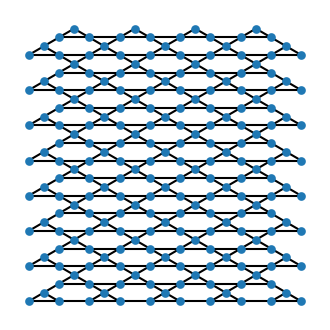

In [36]:
#show that, under this qubit dictionary, one recovers the Kagome graph! Hurra!
nx.draw(simplify_Kag_graph, final_qubit_dictionary, node_size = 10)

In [37]:
#saving the dict and graph for future use.

import pickle

np.save("./data/dict_qbit_to_lattice_periodic.npy", final_qubit_dictionary)

#add the graph itself
pickle.dump(simplify_Kag_graph, open('./data/Kag_graph_periodic.pickle', 'wb'))


# List of edges for Stephan

In [38]:
#make a graph with majority rule, for the fourier transform. 
#for all pre-imposed two-chains, remove the second one, reconnect to other sites
#then cut open the periodic boundary condition
periodic_graph = nx.Graph()
big_graph = Kag_periodic
all_edges_kag = [e for e in big_graph.edges()] 
all_nodes_kag = []
for m in big_graph.nodes:
    edges_to_it = big_graph.edges(m)
    if len(edges_to_it) > 0:
        all_nodes_kag.append(m)
        periodic_graph.add_node(m)
for e in all_edges_kag:
    periodic_graph.add_edge(*e)


#remove the second site of the two chains, and replug the graph
to_remove = []
to_add = []
node_remove = []
for twoch in current_twochains:
    #print("treating this 2chain", twoch)
    node_remove.append(twoch[1])
    temp_edges_to_modify = periodic_graph.edges(twoch[1])
    #print(temp_edges_to_modify)
    for edge in temp_edges_to_modify:
        #print("Modifying this edges", edge)
        to_remove.append(edge)
        if edge != twoch and edge != Reverse(twoch):
            new_link = twoch[1]
            for m in range(2):
                if edge[m] != twoch[1]:
                    new_link = edge[m]
            edge_add = (twoch[0], new_link)
            to_add.append(edge_add)


periodic_graph.remove_edges_from(to_remove)
periodic_graph.add_edges_from(to_add)
periodic_graph.remove_nodes_from(node_remove)

#get the "relaxed" graph for the Zephyr kagome lattice
#this is close to the ideal graph
#test, planar_embed = nx.check_planarity(simplify_Kag_graph)
#pos = nx.combinatorial_embedding_to_pos(planar_embed, fully_triangulate=True)
#pos=nx.spring_layout(simplify_Kag_graph, dim = 2, k=10,iterations = 1000, pos = pos, scale = 40)
#nx.draw(simplify_Kag_graph, pos, node_size = 25)


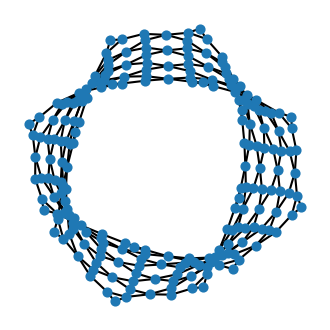

In [39]:
pos=nx.spring_layout(periodic_graph, dim = 2, k=1,iterations = 1000,scale = 40)
nx.draw(periodic_graph, pos = pos, node_size = 15)

In [40]:
newG = nx.convert_node_labels_to_integers(periodic_graph, first_label=0, ordering='default')

In [41]:
np.save("./data/edges_periodic.npy", newG.edges)

# coloring the lattice

First, a poor attempt

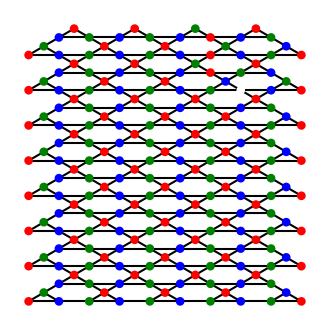

In [42]:
coloring = nx.coloring.greedy_color(simplify_Kag_graph, strategy="connected_sequential")
#coloring = nx.coloring.equitable_color(simplify_Kag_graph, 5)

#inspect the coloring
color_map = []
for node in simplify_Kag_graph:
    if coloring[node] == 0:
        color_map.append('blue')
    elif coloring[node] == 1:
        color_map.append('green')
    elif coloring[node] == 2:
        color_map.append('red')
    else: 
        color_map.append('white')  

nx.draw(simplify_Kag_graph, pos = final_qubit_dictionary, node_size = 10, node_color=color_map)

Then, a more intuitive method based on the translation vectors

In [45]:
def distance(v1):
    return np.sqrt(v1[0]**2 + v1[1]**2)

sublatt_dict = {}

#test a given node:
node_test = 8
initial_A = np.array([0.0,0.0])
initial_B = np.array([1.0, 0.0])
initial_C = np.array([0.5, 0.8660254])
vec1 = 2*np.array([1.0, 0.0])
vec2 = 2*np.array([0.5, 0.8660254])
check = 0
Nlim = Mlim = 20
#labels = ["red", "green", "blue"]
labels = ["A", "B", "C"]
for node_test in simplify_Kag_graph.nodes:
    for n in range(-Nlim, Nlim):
        for m in range(-Mlim, Mlim):
            #print(distance(final_qubit_dictionary[node_test] - initial_A - (n*vec1 + m*vec2)))
            if distance(final_qubit_dictionary[node_test] - initial_A - (n*vec1 + m*vec2)) < 10**(-3):
                check = 1
            elif distance(final_qubit_dictionary[node_test] - initial_B - (n*vec1 + m*vec2)) < 10**(-3):
                check = 2
            elif distance(final_qubit_dictionary[node_test] - initial_C - (n*vec1 + m*vec2)) < 10**(-3):
                check = 3
            if check != 0:
                sublatt_dict.update({node_test: labels[check-1]})

print(sublatt_dict)


{8: 'B', 9: 'B', 10: 'B', 11: 'B', 12: 'A', 13: 'A', 14: 'A', 15: 'A', 24: 'A', 40: 'A', 41: 'A', 42: 'A', 43: 'A', 44: 'B', 45: 'B', 46: 'B', 47: 'B', 48: 'A', 49: 'A', 50: 'A', 51: 'A', 52: 'B', 53: 'B', 54: 'B', 55: 'B', 64: 'A', 71: 'B', 72: 'B', 73: 'B', 74: 'B', 75: 'B', 76: 'A', 77: 'A', 78: 'A', 79: 'A', 80: 'B', 81: 'B', 82: 'B', 83: 'B', 84: 'A', 85: 'A', 86: 'A', 87: 'A', 88: 'A', 104: 'A', 105: 'A', 106: 'A', 107: 'A', 108: 'B', 109: 'B', 110: 'B', 111: 'B', 112: 'A', 113: 'A', 114: 'A', 115: 'A', 116: 'B', 117: 'B', 118: 'B', 119: 'B', 127: 'B', 128: 'A', 135: 'A', 136: 'B', 137: 'B', 138: 'B', 139: 'B', 140: 'A', 141: 'A', 142: 'A', 143: 'A', 144: 'B', 145: 'B', 146: 'B', 147: 'B', 148: 'A', 149: 'A', 150: 'A', 152: 'A', 168: 'A', 169: 'A', 170: 'A', 171: 'A', 172: 'B', 173: 'B', 174: 'B', 175: 'B', 176: 'A', 177: 'A', 178: 'A', 179: 'A', 180: 'B', 181: 'B', 182: 'B', 183: 'B', 200: 'B', 201: 'B', 202: 'B', 203: 'B', 204: 'A', 205: 'A', 206: 'A', 207: 'A', 208: 'B', 209: 

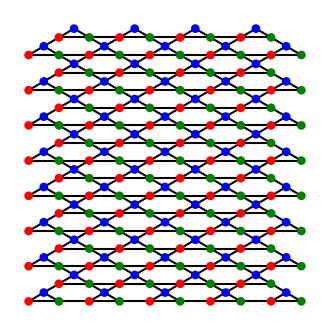

In [46]:
color_map = []
label_to_color = {"A":"red", "B":"green", "C":"blue"}
for node in simplify_Kag_graph.nodes:
    color_map.append(label_to_color[sublatt_dict[node]])
nx.draw(simplify_Kag_graph, pos = final_qubit_dictionary, node_size = 10, node_color=color_map)

In [47]:
np.save("./data/sublattices.npy", sublatt_dict)